In [1]:
import os, glob,inspect
import copy
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 200)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import rankdata
from scipy import stats
from datetime import datetime, timedelta

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, _tree
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import mixture
from math import pi
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from kneed import DataGenerator, KneeLocator
from sklearn import tree
import string
from sklearn.tree import export_text
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
import sympy as sym
from sympy import solve


cwd = os.getcwd()
today = datetime.today().strftime('%Y-%m-%d')
min_cluster = 3
price_step = 0.01

print(cwd)
print(today)

/home/cst/SmartTradzt/PriceOptimisation
2021-07-26


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def export_py_code(tree, feature_names, max_depth=100, spacing=4):
    if spacing < 2:
        raise ValueError('spacing must be > 1')

    # Clean up feature names (for correctness)
    nums = string.digits
    alnums = string.ascii_letters + nums
    clean = lambda s: ''.join(c if c in alnums else '_' for c in s)
    features = [clean(x) for x in feature_names]
    features = ['_'+x if x[0] in nums else x for x in features if x]
    if len(set(features)) != len(feature_names):
        raise ValueError('invalid feature names')

    # First: export tree to text
    res = export_text(tree, feature_names=features, 
                        max_depth=max_depth,
                        decimals=6,
                        spacing=spacing-1)

    # Second: generate Python code from the text
    skip, dash = ' '*spacing, '-'*(spacing-1)
    code = 'def decision_tree({}):\n'.format(', '.join(features))
    for line in repr(tree).split('\n'):
        code += skip + "# " + line + '\n'
    for line in res.split('\n'):
        line = line.rstrip().replace('|',' ')
        if '<' in line or '>' in line:
            line, val = line.rsplit(maxsplit=1)
            line = line.replace(' ' + dash, 'if')
            line = '{} {:g}:'.format(line, float(val))
        else:
            line = line.replace(' {} class:'.format(dash), 'return')
        code += skip + line + '\n'

    return code.replace('- value:','return').replace('-','')

def get_func_args(f):
    if hasattr(f, 'args'):
        return f.args
    else:
        return list(inspect.signature(f).parameters)

def tree_to_df(reg_tree, feature_names):
    tree_ = reg_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, row, ret):
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Add rule to row and search left branch
            row[-1].append(name + " <= " +  str(threshold))
            recurse(tree_.children_left[node], row, ret)
            # Add rule to row and search right branch
            row[-1].append(name + " > " +  str(threshold))
            recurse(tree_.children_right[node], row, ret)
        else:
            # Add output rules and start a new row
            label = tree_.value[node]
            ret.append("return " + str(label[0][0]))
            row.append([])
    
    # Initialize
    rules = [[]]
    vals = []
    
    # Call recursive function with initial values
    recurse(0, rules, vals)
    
    # Convert to table and output
    df = pd.DataFrame(rules).dropna(how='all')
    df['Return'] = pd.Series(vals)
    return df


In [3]:
filename = 'Price_Opti_Input.csv'
filepath = os.path.join(cwd,filename)
print(filepath)

/home/cst/SmartTradzt/PriceOptimisation/Price_Opti_Input.csv


In [4]:
df = pd.read_csv(filepath)
df.head()

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25


In [5]:
df.shape

(2147, 10)

In [6]:
df['Price'] = df['Revenue_L12']/df['l12_sales_vol']

In [7]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,Price
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,20.948276
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,43.846154
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,60.564103
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,37.752809
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,112.500000
...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,30.312500
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,45.769231
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,25.312500
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,136.666667


In [8]:
df['log_qty'] = np.log(df['l12_sales_vol'])

In [9]:
standard_cost = df['standard_cost'].unique()[0]
standard_cost

10

# Concept

In [10]:
filename = 'Price_Opti_Input.csv'
filepath = os.path.join(cwd,filename)
print(filepath)

/home/cst/SmartTradzt/RML/Price_Opti_Input.csv


In [11]:
df = pd.read_csv(filepath)
df.head()

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25


In [12]:
df['Price'] = df['Revenue_L12']/df['l12_sales_vol']

In [13]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,Price
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,20.948276
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,43.846154
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,60.564103
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,37.752809
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,112.500000
...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,30.312500
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,45.769231
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,25.312500
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,136.666667


In [14]:
# # revenue
# revenue = quantity * price # eq (1)
# # profit
# profit = revenue - cost # eq (2)

<AxesSubplot:>

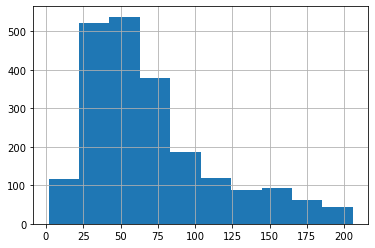

In [15]:
df['Price'].hist()

In [16]:
df['Price'].min(), df['Price'].max()

(1.7246835443037973, 205.83333333333334)

In [17]:
df['log_qty'] = np.log(df['l12_sales_vol'])

In [18]:
standard_cost = df['standard_cost'].unique()[0]
standard_cost

10

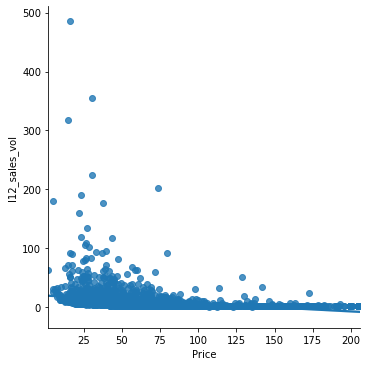

In [19]:
sns.lmplot(x = "Price", y = "l12_sales_vol", data = df)

In [20]:
# fit OLS model
model = ols("l12_sales_vol ~ Price", data = df).fit()
# print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          l12_sales_vol   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     168.1
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           4.49e-37
Time:                        09:10:08   Log-Likelihood:                -9551.6
No. Observations:                2147   AIC:                         1.911e+04
Df Residuals:                    2145   BIC:                         1.912e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.5588      0.852     22.948      0.0

In [21]:
# # plugging regression coefficients
# quantity = 19.5588  - 0.1340 * price # eq (5)
# # the profit function in eq (3) becomes
# profit = (19.5588  - 0.1340 * price) * price - cost # eq (6)

In [22]:
# (1.7246835443037973, 205.83333333333334)
step = 0.01
Price = [i for i in np.arange(df['Price'].min(), df['Price'].max(), step)]
Price

[1.7246835443037973,
 1.7346835443037973,
 1.7446835443037974,
 1.7546835443037974,
 1.7646835443037974,
 1.7746835443037974,
 1.7846835443037974,
 1.7946835443037974,
 1.8046835443037974,
 1.8146835443037974,
 1.8246835443037974,
 1.8346835443037974,
 1.8446835443037974,
 1.8546835443037974,
 1.8646835443037975,
 1.8746835443037975,
 1.8846835443037975,
 1.8946835443037975,
 1.9046835443037975,
 1.9146835443037975,
 1.9246835443037975,
 1.9346835443037975,
 1.9446835443037975,
 1.9546835443037975,
 1.9646835443037975,
 1.9746835443037976,
 1.9846835443037976,
 1.9946835443037976,
 2.0046835443037976,
 2.0146835443037974,
 2.0246835443037976,
 2.034683544303798,
 2.0446835443037976,
 2.0546835443037974,
 2.0646835443037976,
 2.074683544303798,
 2.0846835443037977,
 2.0946835443037974,
 2.1046835443037977,
 2.114683544303798,
 2.1246835443037977,
 2.1346835443037975,
 2.1446835443037977,
 2.154683544303798,
 2.1646835443037977,
 2.1746835443037975,
 2.1846835443037977,
 2.19468354430379

In [23]:
# a range of diffferent prices to find the optimum one
# Price = [320, 330, 340, 350, 360, 370, 380, 390]
# assuming a fixed cost
cost = df['standard_cost'].unique()[0]
Revenue = []
for i in Price:
    quantity_demanded = 19.5588 - 0.1340 * i
   
    # profit function
    Revenue.append((i-cost) * quantity_demanded)
# create data frame of price and revenue
profit = pd.DataFrame({"Price": Price, "Revenue": Revenue})

In [24]:
profit

,Price,Revenue
0,1.724684,-159.942771
1,1.734684,-159.738419
2,1.744684,-159.534093
3,1.754684,-159.329794
4,1.764684,-159.125522
...,...,...
20406,205.784684,-1569.478077
20407,205.794684,-1569.820605
20408,205.804684,-1570.163161
20409,205.814684,-1570.505743


In [25]:
# price at which revenue is maximum
profit[profit['Revenue'] == profit['Revenue'].max()]

,Price,Revenue
7626,77.984684,619.262448


In [26]:
# price at which revenue is maximum
np.array(profit[profit['Revenue'] == profit['Revenue'].max()]['Price'])[0]

77.98468354430386

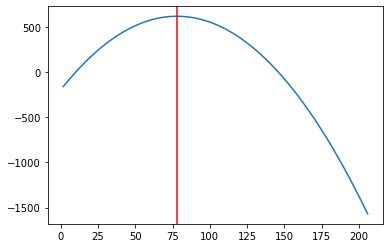

In [27]:
#plot revenue against price
plt.plot(profit["Price"], profit["Revenue"])
plt.axvline(x=np.array(profit[profit['Revenue'] == profit['Revenue'].max()]['Price'])[0], c='red')

# Segmentation

In [28]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,Price,log_qty
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,20.948276,2.451005
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,43.846154,2.660260
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,60.564103,3.663562
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,37.752809,2.186051
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,112.500000,0.182322
...,...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,30.312500,2.261763
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,45.769231,0.955511
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,25.312500,1.856298
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,136.666667,0.182322


In [29]:
# Since this is not our data so we do not have understanding about the data therefore just throw all the features  
features = ['Recency', 'Avg_Price_L3Y', 'Revenue_L12',
       'Customer_Size', 'l3y_volume', 'standard_cost', 'l12_sales_vol',
       'Current_Price', 'Price', 'log_qty']

In [30]:
Scaler = StandardScaler()
X_std = Scaler.fit_transform(df[features])
X_std_df = pd.DataFrame(X_std,columns=features)

pca = PCA(random_state=42)
pca_scale = pca.fit_transform(X_std_df)
pca_scale_df = pd.DataFrame(pca_scale)
pca_scale_df.columns = ['PC_'+str(item) for item in pca_scale_df.columns]
pca_scale_df

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9
0,1.344240,-2.239635,0.027844,1.354850,1.393647,-0.354224,-0.126330,-0.001095,-4.749726e-16,-1.302188e-18
1,0.608357,0.765456,-0.881038,0.433526,-0.069875,-0.169863,-0.229653,0.000501,1.272561e-14,-3.407768e-18
2,3.037295,2.712291,-0.313025,-0.178335,-0.320599,-1.021979,0.138651,0.001186,-4.501552e-16,2.263631e-18
3,0.886591,-0.986220,-0.355969,0.234265,1.299653,-0.180068,0.055968,0.000956,2.074955e-16,8.392530e-19
4,-1.643740,-1.269238,1.829639,1.142067,-0.372763,-0.059957,0.084294,0.000698,-3.167643e-17,1.020117e-18
...,...,...,...,...,...,...,...,...,...,...
2142,0.857589,-3.212310,0.369459,1.532988,-0.522772,-0.508206,-0.303724,0.000649,-1.394933e-16,-2.376547e-19
2143,-0.372902,-2.296393,0.333226,0.557818,-0.441387,0.107085,0.389956,-0.000823,1.343518e-16,-2.242476e-19
2144,0.117894,-1.173905,-0.722696,0.481011,-0.282119,0.152726,0.129478,0.000963,1.596277e-16,-4.102320e-19
2145,-1.372112,-0.227393,1.100126,-1.671036,-0.068514,0.335839,0.108861,-0.000714,1.421429e-16,1.637150e-19


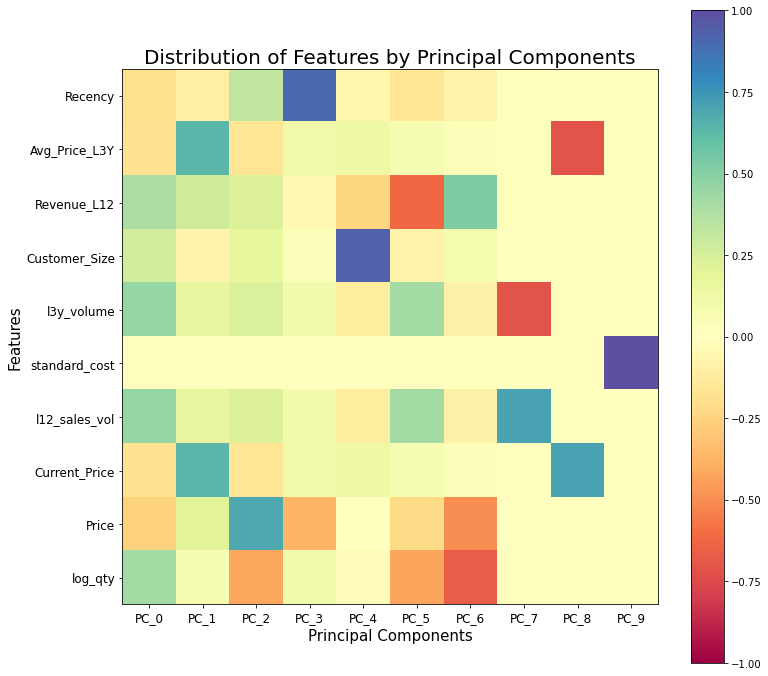

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap = 'Spectral', vmin =-1, vmax = 1)

plt.yticks(range(len(features)), features, fontsize=12)
plt.xticks(range(len(pca_scale_df.columns)), pca_scale_df.columns,fontsize=12)
plt.xlabel('Principal Components',
           fontsize=15)
plt.ylabel('Features',
           fontsize=15)
plt.title('Distribution of Features by Principal Components',
          fontsize=20)
plt.colorbar()
plt.show()


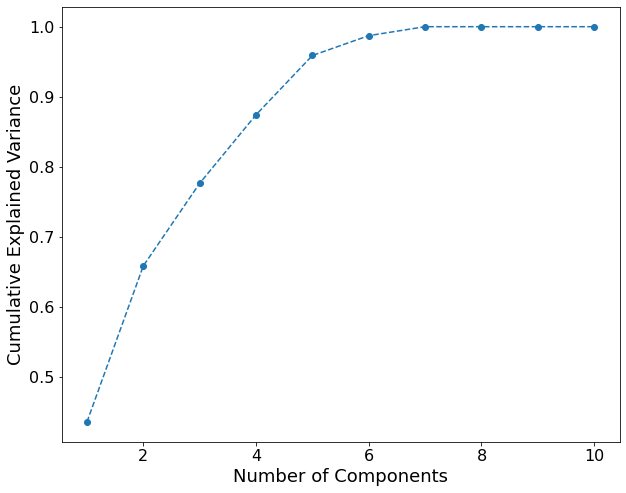

In [32]:
evr = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(features)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [33]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)

Number of components: 4


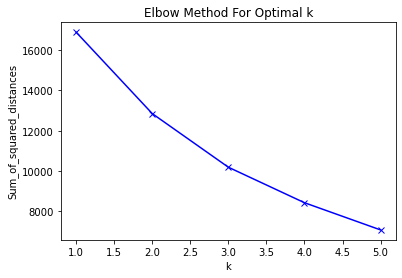

In [34]:
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(pca_scale_df.iloc[:,0:n_comps])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [35]:
kl = KneeLocator(range(1, 6), Sum_of_squared_distances, curve="convex", direction="decreasing")
print('Suggested number of clusters:',kl.elbow)

if kl.elbow is None or kl.elbow<min_cluster:
    n_clusters = min_cluster
else:
    n_clusters = kl.elbow
    
print('n_clusters:',n_clusters)


Suggested number of clusters: None
n_clusters: 3


/home/cst/anaconda3/lib/python3.8/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


In [36]:
clustering = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_scale_df)

In [37]:
df['Cluster'] = clustering.labels_
X_std_df['Cluster'] = clustering.labels_
pca_scale_df['Cluster'] = clustering.labels_

/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


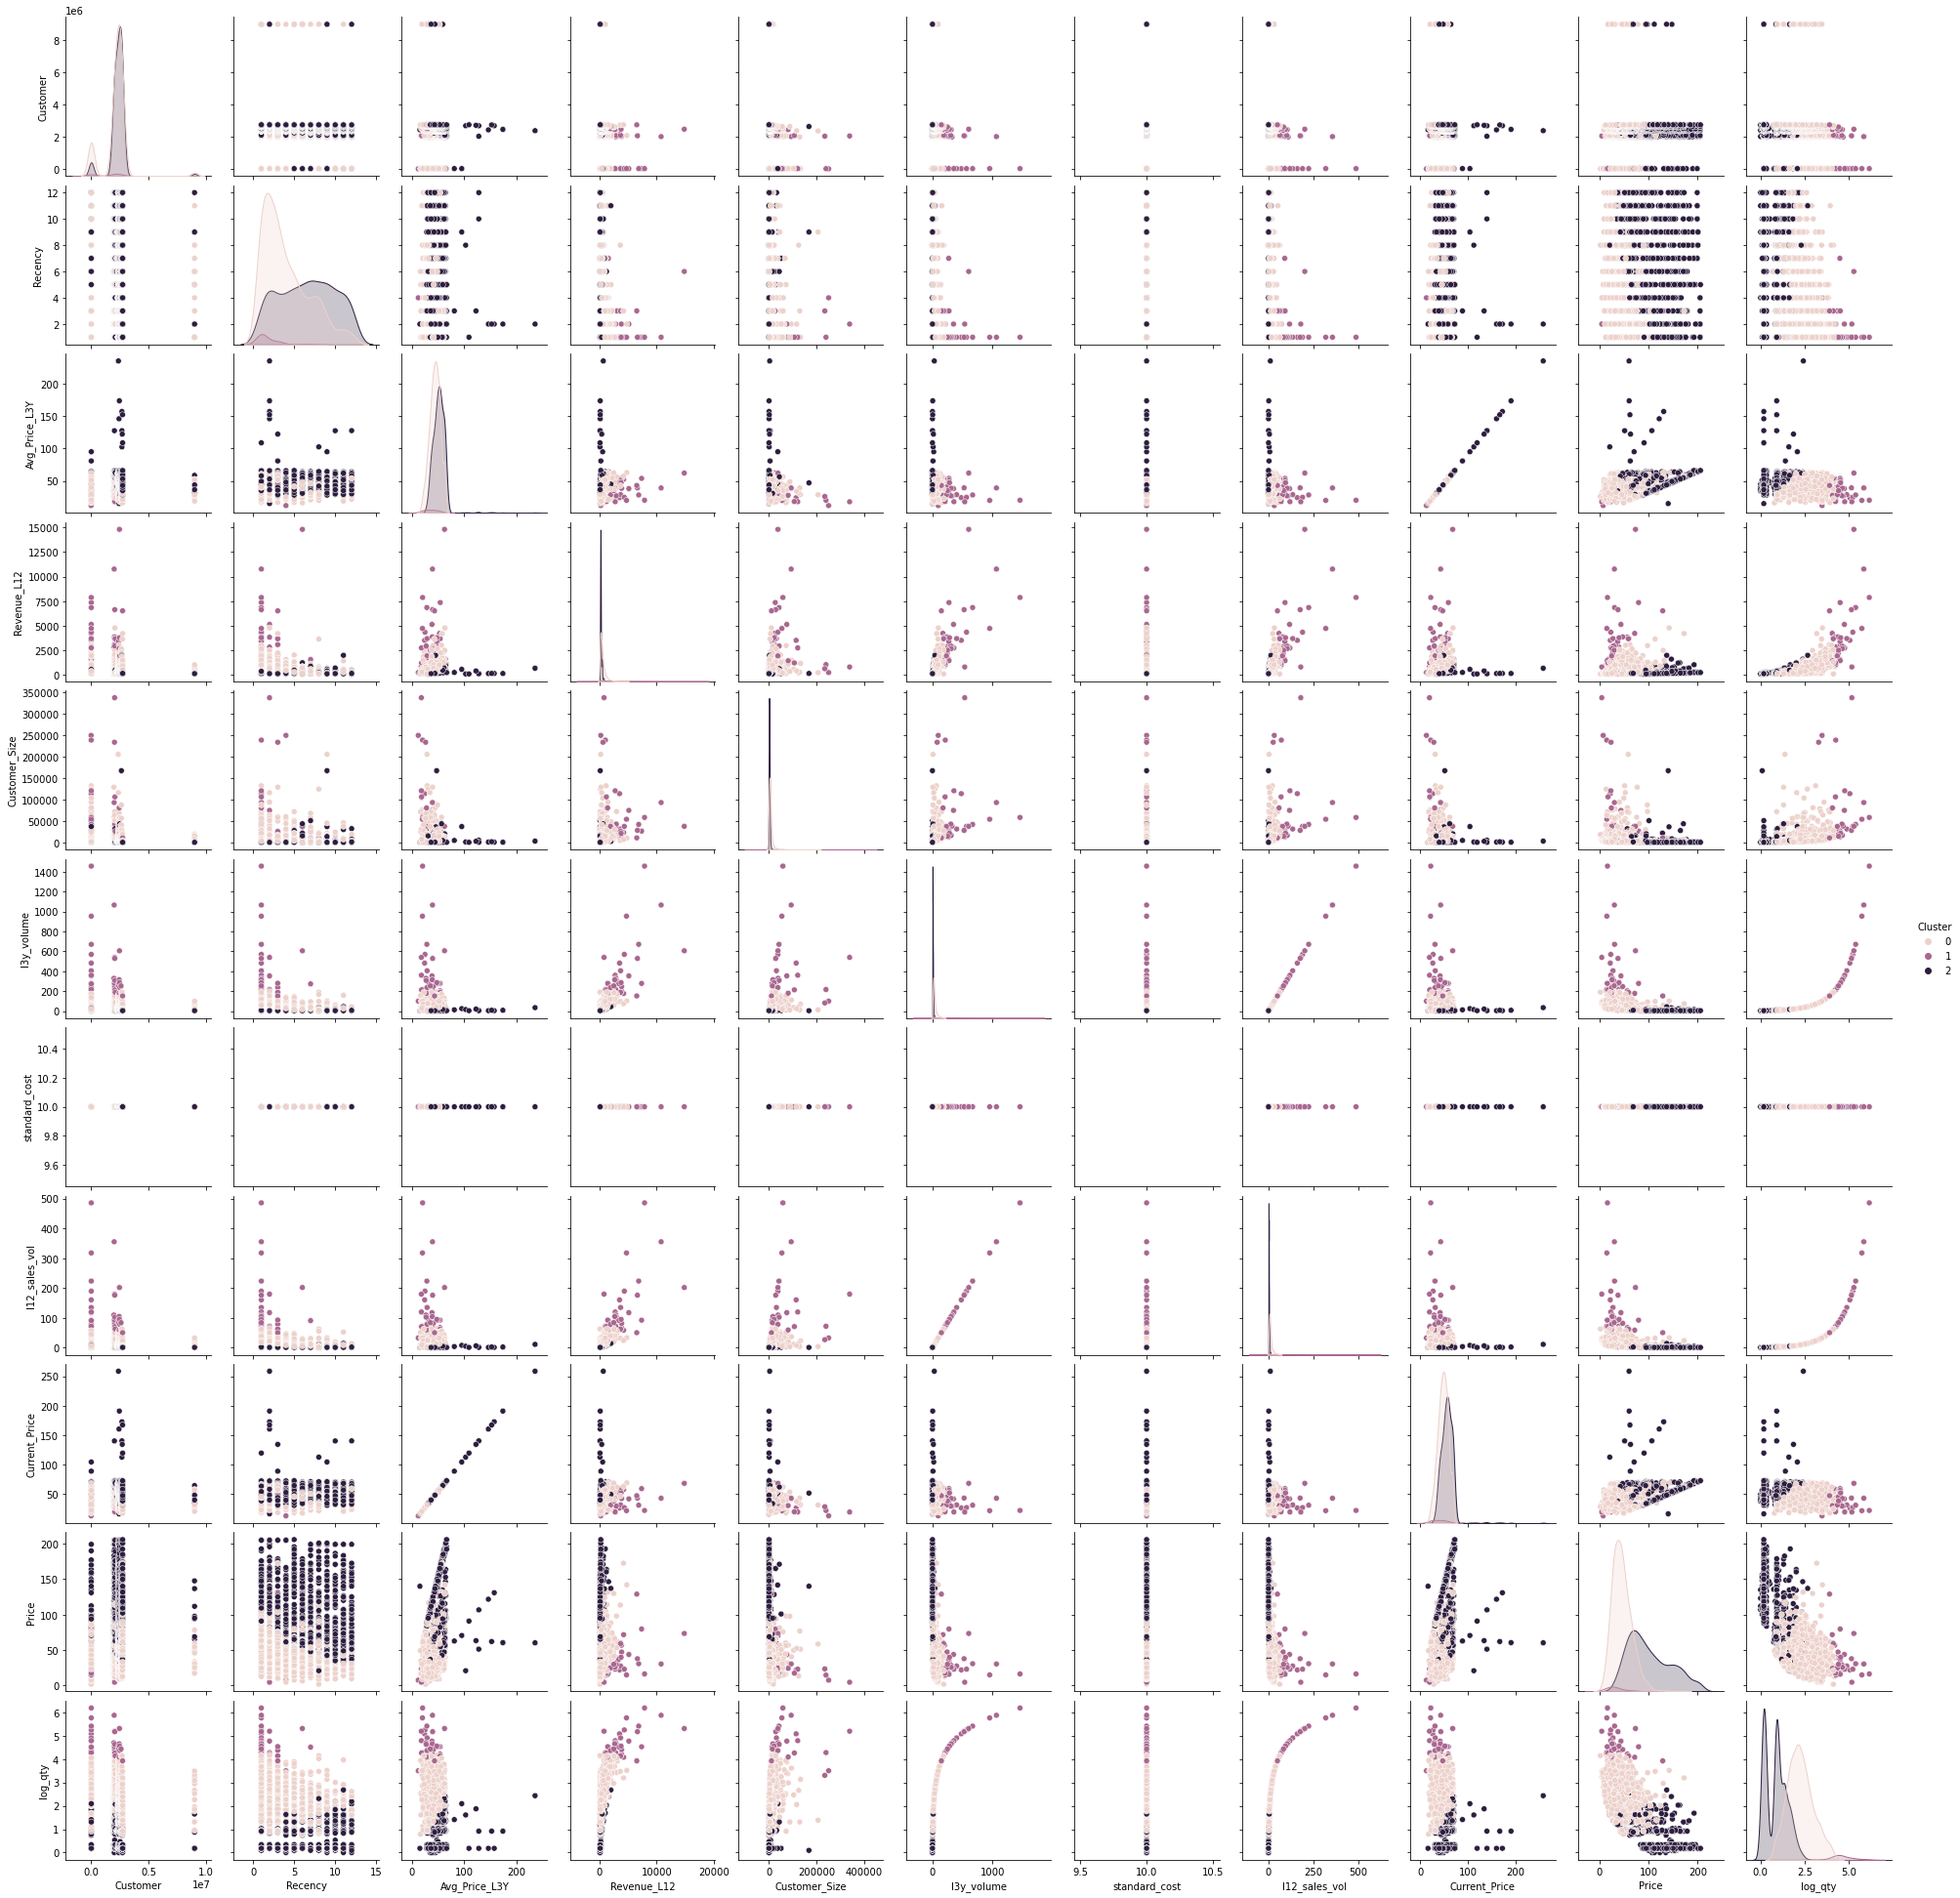

In [38]:
sns.pairplot(df,hue='Cluster')

In [39]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(df[features],df['Cluster'])

DecisionTreeClassifier(random_state=42)

In [40]:
text_representation = tree.export_text(clf, feature_names=features)
print(text_representation)

|--- l3y_volume <= 13.86
|   |--- Price <= 54.83
|   |   |--- Recency <= 8.50
|   |   |   |--- Recency <= 6.50
|   |   |   |   |--- Current_Price <= 57.36
|   |   |   |   |   |--- Price <= 51.95
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Price >  51.95
|   |   |   |   |   |   |--- Price <= 52.13
|   |   |   |   |   |   |   |--- Avg_Price_L3Y <= 38.20
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Avg_Price_L3Y >  38.20
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- Price >  52.13
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Current_Price >  57.36
|   |   |   |   |   |--- class: 2
|   |   |   |--- Recency >  6.50
|   |   |   |   |--- Current_Price <= 44.88
|   |   |   |   |   |--- Price <= 53.96
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Price >  53.96
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- Current_Price >  44.88
|   |   |   |   |   |--- Avg_Price_L3Y

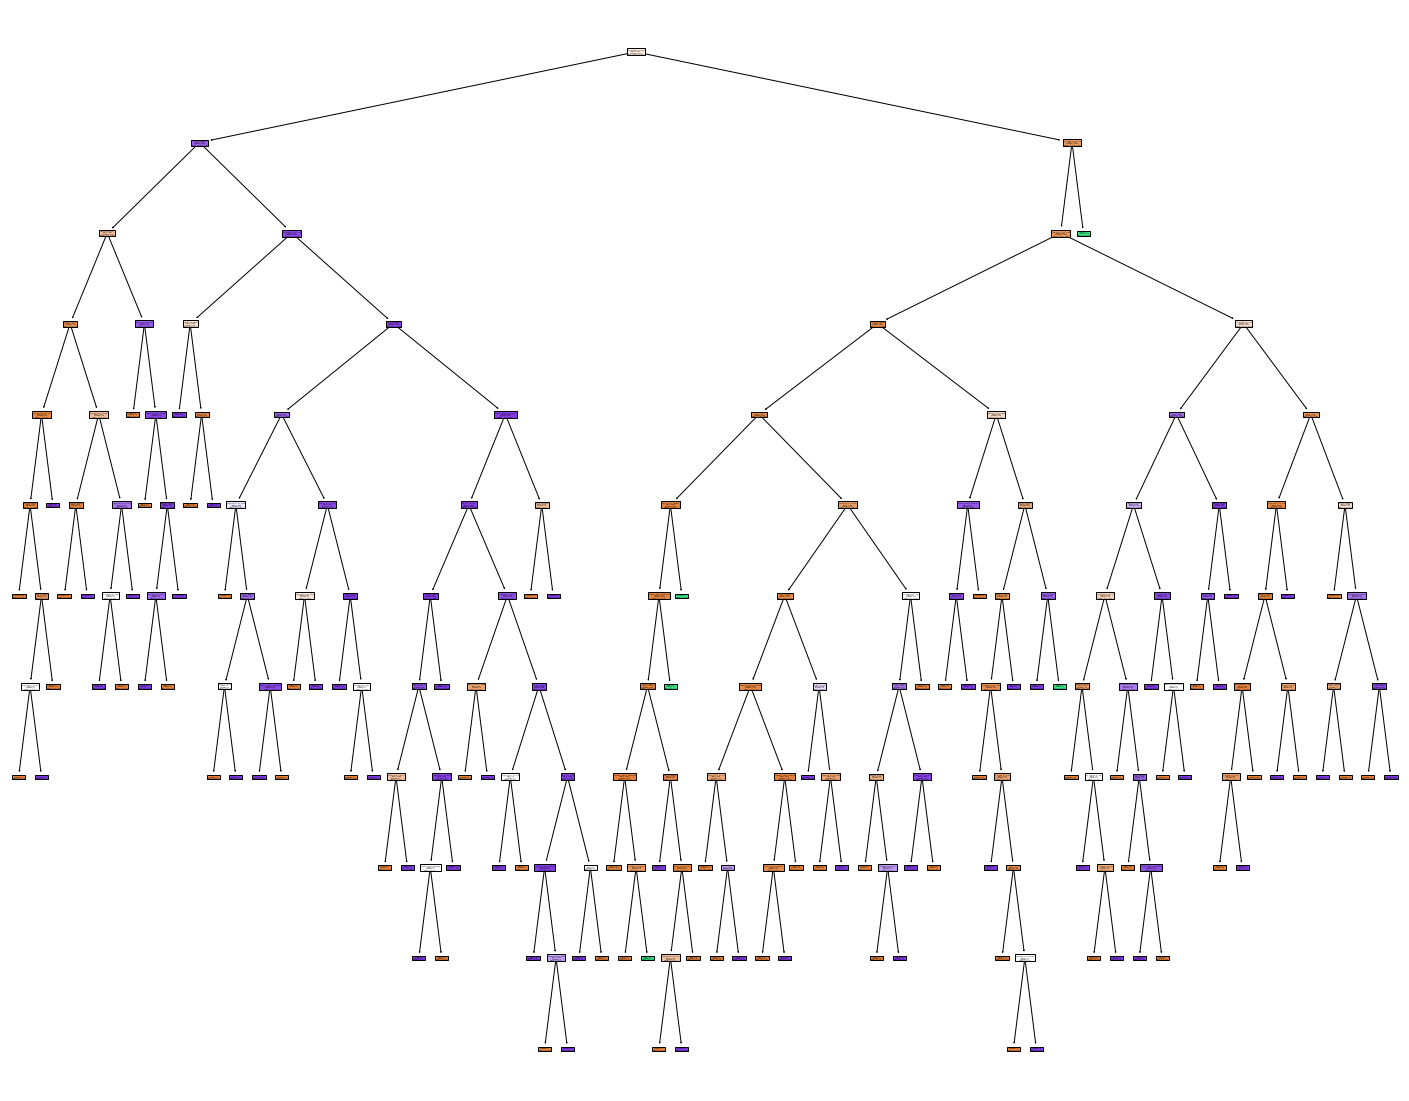

In [41]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,
                   filled=True)

In [42]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [43]:
rules = get_rules(clf, features, None)
rules_dict = {}
for i,r in enumerate(rules):    
    rules_dict[i] = r
    

In [44]:
rules_dict

{0: 'if (l3y_volume > 13.855) and (l3y_volume <= 201.625) and (Avg_Price_L3Y <= 54.05) and (Price <= 79.546) and (Recency <= 7.5) and (Revenue_L12 <= 3388.5) and (Customer_Size <= 183261.07) and (Price <= 66.449) and (Customer_Size <= 79655.469) then response: 621.0 | based on 621 samples',
 1: 'if (l3y_volume <= 13.855) and (Price > 54.832) and (Avg_Price_L3Y > 31.75) and (Price > 64.497) and (Customer_Size <= 69248.533) and (log_qty <= 1.112) and (Price > 71.67) then response: 0.0 | based on 541 samples',
 2: 'if (l3y_volume > 13.855) and (l3y_volume <= 201.625) and (Avg_Price_L3Y <= 54.05) and (Price <= 79.546) and (Recency > 7.5) and (Current_Price <= 54.45) and (Price <= 57.801) and (Customer_Size > 1364.645) and (Customer_Size > 1550.18) then response: 91.0 | based on 91 samples',
 3: 'if (l3y_volume > 13.855) and (l3y_volume <= 201.625) and (Avg_Price_L3Y > 54.05) and (l3y_volume > 23.28) and (Recency <= 5.5) and (Avg_Price_L3Y <= 63.6) and (Price <= 103.231) and (l12_sales_vol 

In [45]:
rules_df = tree_to_df(clf, features)

In [46]:
rules_df

,0,1,2,3,4,5,6,7,8,Return
0,l3y_volume <= 13.855000019073486,Price <= 54.83243179321289,Recency <= 8.5,Recency <= 6.5,Current_Price <= 57.364999771118164,Price <= 51.945945739746094,None,None,None,return 63.0
1,Price > 51.945945739746094,Price <= 52.13371276855469,Avg_Price_L3Y <= 38.19999885559082,None,None,None,None,None,None,return 2.0
2,Avg_Price_L3Y > 38.19999885559082,None,None,None,None,None,None,None,None,return 0.0
3,Price > 52.13371276855469,None,None,None,None,None,None,None,None,return 10.0
4,Current_Price > 57.364999771118164,None,None,None,None,None,None,None,None,return 0.0
...,...,...,...,...,...,...,...,...,...,...
101,Price > 46.53837966918945,Current_Price <= 64.23999977111816,Price <= 48.87568283081055,None,None,None,None,None,None,return 0.0
102,Price > 48.87568283081055,None,None,None,None,None,None,None,None,return 3.0
103,Current_Price > 64.23999977111816,Price <= 47.11435508728027,None,None,None,None,None,None,None,return 1.0
104,Price > 47.11435508728027,None,None,None,None,None,None,None,None,return 0.0


In [47]:
df_ = pd.concat([df[features], df['Cluster']], axis=1)
df_

,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,Price,log_qty,Cluster
0,9,29.3,243,38827.46,34.89,10,11.6,32.23,20.948276,2.451005,0
1,5,53.6,627,4051.66,42.84,10,14.3,58.96,43.846154,2.660260,0
2,2,60.6,2362,12182.45,116.86,10,39.0,66.66,60.564103,3.663562,0
3,5,39.8,336,31729.38,26.61,10,8.9,43.78,37.752809,2.186051,0
4,12,37.5,135,135.11,3.60,10,1.2,41.25,112.500000,0.182322,2
...,...,...,...,...,...,...,...,...,...,...,...
2142,11,18.8,291,7520.45,28.74,10,9.6,20.68,30.312500,2.261763,0
2143,8,28.7,119,1365.62,7.90,10,2.6,31.57,45.769231,0.955511,0
2144,6,38.9,162,1165.76,19.11,10,6.4,42.79,25.312500,1.856298,0
2145,2,43.8,164,456.95,3.74,10,1.2,48.18,136.666667,0.182322,2


In [48]:
res = export_py_code(clf, feature_names=features, spacing=4)
print(res)

def decision_tree(Recency, Avg_Price_L3Y, Revenue_L12, Customer_Size, l3y_volume, standard_cost, l12_sales_vol, Current_Price, Price, log_qty):
    # DecisionTreeClassifier(random_state=42)
    if l3y_volume <= 13.855:
        if Price <= 54.8324:
            if Recency <= 8.5:
                if Recency <= 6.5:
                    if Current_Price <= 57.365:
                        if Price <= 51.9459:
                            return 0
                        if Price > 51.9459:
                            if Price <= 52.1337:
                                if Avg_Price_L3Y <= 38.2:
                                    return 0
                                if Avg_Price_L3Y > 38.2:
                                    return 2
                            if Price > 52.1337:
                                return 0
                    if Current_Price > 57.365:
                        return 2
                if Recency > 6.5:
                    if Current_Price <= 44.88:
        

In [49]:
with open('DecisionTreeRegressorSE_.py', 'a') as f:
    f.write(res)    

In [50]:
from DecisionTreeRegressorSE_ import decision_tree

In [51]:
decision_tree, type(decision_tree)

(<function DecisionTreeRegressorSE_.decision_tree(Recency, Avg_Price_L3Y, Revenue_L12, Customer_Size, l3y_volume, standard_cost, l12_sales_vol, Current_Price, Price, log_qty)>,
 function)

In [52]:
print(decision_tree.__name__ ,get_func_args(decision_tree))

decision_tree ['Recency', 'Avg_Price_L3Y', 'Revenue_L12', 'Customer_Size', 'l3y_volume', 'standard_cost', 'l12_sales_vol', 'Current_Price', 'Price', 'log_qty']


In [53]:
text_function = str(decision_tree.__name__)+'('+','.join([item+"=x['"+item+"']" for item in get_func_args(decision_tree)])+')'

In [54]:
df['node'] = df.apply(lambda x: eval(text_function), axis=1) 

In [55]:
# can this be robust?

# df['node'] = df.apply(lambda x: decision_tree(x['Recency'],x['Avg_Price_L3Y'],x[ 'Revenue_L12'],x['Customer_Size'],x['l3y_volume'],x['standard_cost'],x['l12_sales_vol'],x['Current_Price'],x['Price'],x['log_qty']), axis=1)



# df[features].apply(decision_tree)

In [57]:
df['segment'] = df['node']

In [58]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,Price,log_qty,Cluster,node,segment
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,20.948276,2.451005,0,0,0
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,43.846154,2.660260,0,0,0
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,60.564103,3.663562,0,0,0
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,37.752809,2.186051,0,0,0
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,112.500000,0.182322,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,30.312500,2.261763,0,0,0
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,45.769231,0.955511,0,0,0
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,25.312500,1.856298,0,0,0
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,136.666667,0.182322,2,2,2


# Elastisicity Function per Segment

In [61]:
# #Perform data transformation for the price elasticity analysis (Log-Log)
df = df.loc[df['l3y_volume']>0]
df = df.loc[df['Avg_Price_L3Y']>0]


In [62]:
df.shape

(2147, 15)

In [63]:
df.loc[:,'lnvolume'] = np.log(df.loc[:,'l3y_volume'])
df.loc[:,'lnAvg_Price_L3Y'] = np.log(df.loc[:,'Avg_Price_L3Y'])

In [95]:
# features = ['Recency',
#  'Avg_Price_L3Y',
#  'Revenue_L12',
#  'Customer_Size',
#  'l3y_volume',
#  'standard_cost', 
#  'Current_Price',
#  'Price',
#  'log_qty']
# target = ['l12_sales_vol']

features = ['Price']
target = ['l12_sales_vol']

In [96]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,Price,log_qty,Cluster,node,segment,lnvolume,lnAvg_Price_L3Y,elasticity
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,20.948276,2.451005,0,0,0,3.552200,3.377588,"{'intercept_': 24.302158800947694, 'coef_': [-..."
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,43.846154,2.660260,0,0,0,3.757472,3.981549,"{'intercept_': 24.302158800947694, 'coef_': [-..."
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,60.564103,3.663562,0,0,0,4.760977,4.104295,"{'intercept_': 24.302158800947694, 'coef_': [-..."
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,37.752809,2.186051,0,0,0,3.281287,3.683867,"{'intercept_': 24.302158800947694, 'coef_': [-..."
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,112.500000,0.182322,2,2,2,1.280934,3.624341,"{'intercept_': 5.547153742679182, 'coef_': [-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,30.312500,2.261763,0,0,0,3.358290,2.933857,"{'intercept_': 24.302158800947694, 'coef_': [-..."
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,45.769231,0.955511,0,0,0,2.066863,3.356897,"{'intercept_': 24.302158800947694, 'coef_': [-..."
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,25.312500,1.856298,0,0,0,2.950212,3.660994,"{'intercept_': 24.302158800947694, 'coef_': [-..."
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,136.666667,0.182322,2,2,2,1.319086,3.779634,"{'intercept_': 5.547153742679182, 'coef_': [-0..."


In [97]:
lin_regs = {}

for segment in df['segment'].unique():
    
    print('segment:',segment)
    sub = df[df['segment']==segment]
    
    lin_reg = LinearRegression()
    lin_reg.fit(sub[features].values,sub[target].values.reshape(-1, 1))
    print(lin_reg.intercept_,lin_reg.coef_)
    
    lin_regs[segment] = {}
    lin_regs[segment]['intercept_'] = lin_reg.intercept_[0]
    lin_regs[segment]['coef_'] = lin_reg.coef_[0]
    
#     X_train = sub['lnAvg_Price_L3Y'].values.reshape(-1, 1)
#     y_train = sub['lnvolume'].values.reshape(-1, 1)
    
#     lin_reg = sm.add_constant(np.array(X_train))
#     ls=sm.OLS(np.array(y_train,dtype=float),np.array(X_train,dtype=float)).fit()
#     print(ls.summary())
    
    
#     print('\n')
#     print('---------------------------------------------')
    

segment: 0
[16.65617094] [[-0.09138471]]
segment: 2
[5.25287383] [[-0.02343316]]
segment: 1
[155.46571994] [[-0.89595596]]


In [98]:
lin_regs

{0: {'intercept_': 16.656170942696097, 'coef_': array([-0.09138471])},
 2: {'intercept_': 5.2528738293584345, 'coef_': array([-0.02343316])},
 1: {'intercept_': 155.46571994208065, 'coef_': array([-0.89595596])}}

In [99]:
df['elasticity'] = df['segment'].map(lin_regs)

In [100]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,Price,log_qty,Cluster,node,segment,lnvolume,lnAvg_Price_L3Y,elasticity
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,20.948276,2.451005,0,0,0,3.552200,3.377588,"{'intercept_': 16.656170942696097, 'coef_': [-..."
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,43.846154,2.660260,0,0,0,3.757472,3.981549,"{'intercept_': 16.656170942696097, 'coef_': [-..."
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,60.564103,3.663562,0,0,0,4.760977,4.104295,"{'intercept_': 16.656170942696097, 'coef_': [-..."
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,37.752809,2.186051,0,0,0,3.281287,3.683867,"{'intercept_': 16.656170942696097, 'coef_': [-..."
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,112.500000,0.182322,2,2,2,1.280934,3.624341,"{'intercept_': 5.2528738293584345, 'coef_': [-..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,30.312500,2.261763,0,0,0,3.358290,2.933857,"{'intercept_': 16.656170942696097, 'coef_': [-..."
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,45.769231,0.955511,0,0,0,2.066863,3.356897,"{'intercept_': 16.656170942696097, 'coef_': [-..."
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,25.312500,1.856298,0,0,0,2.950212,3.660994,"{'intercept_': 16.656170942696097, 'coef_': [-..."
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,136.666667,0.182322,2,2,2,1.319086,3.779634,"{'intercept_': 5.2528738293584345, 'coef_': [-..."


# Construct Function per Segment

In [107]:
for k,v in lin_regs.items():
    
    print(k,v)
    
    quantity_function_text = str(v['intercept_']) + '+' + '+'.join(['('+str(coef)+'*'+str(feature)+')' for coef,feature in zip(v['coef_'],features) ])    
    profit_function_text = str(v['intercept_']) + '+' + '+'.join(['('+str(coef)+'*'+str(feature)+')' for coef,feature in zip(v['coef_'],features) ]) +'* price - standard_cost'


0 {'intercept_': 16.656170942696097, 'coef_': array([-0.09138471])}
2 {'intercept_': 5.2528738293584345, 'coef_': array([-0.02343316])}
1 {'intercept_': 155.46571994208065, 'coef_': array([-0.89595596])}


In [110]:
quantity_function_text

'155.46571994208065+(-0.8959559562154132*Price)'

# Optimisation per Segment

In [120]:
revenue_df= pd.DataFrame()

for k,v, in lin_regs.items():
    
#     print(k,v)
    
    segment = k
    
    sub_df = df[df['segment']==segment]
    
    min_price = sub_df['Price'].min()
    max_price = sub_df['Price'].max()
    
    Price = [i for i in np.arange(sub_df['Price'].min(), sub_df['Price'].max(), step)]
#     print(segment,Price)

    Revenue = []
    
    for i in Price:
    
        quantity_demanded = eval(quantity_function_text.replace('Price',str(i)))       
        Revenue.append((i-standard_cost) * quantity_demanded)
        
    profit = pd.DataFrame({"Price": Price, "Revenue": Revenue})
    profit['Segment'] = segment 
    
    revenue_df = pd.concat([revenue_df,profit])
    

In [121]:
revenue_df

,Price,Revenue,Segment
0,1.724684,-1273.740676,0
1,1.734684,-1272.127418,0
2,1.744684,-1270.514339,0
3,1.754684,-1268.901439,0
4,1.764684,-1267.288718,0
...,...,...,...
12432,128.847253,4756.772933,1
12433,128.857253,4756.108267,1
12434,128.867253,4755.443421,1
12435,128.877253,4754.778397,1


In [122]:
revenue_df.groupby(['Segment']).aggregate({'Price':[np.min,np.max]})

Price            
              amin        amax
Segment                       
0         1.724684  172.534684
1         4.527253  128.887253
2        20.800000  205.830000

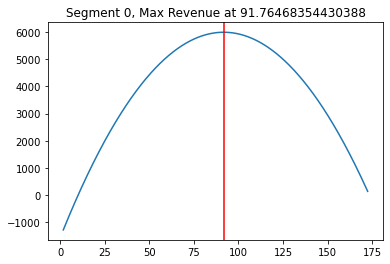

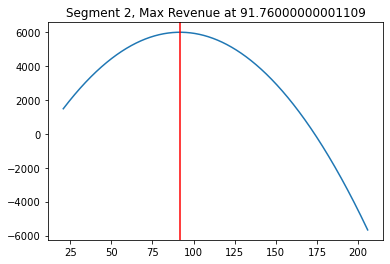

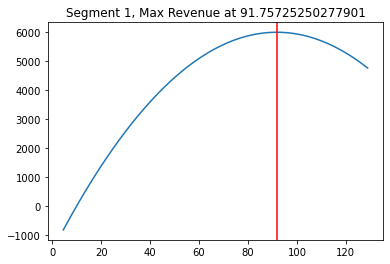

In [124]:
for segment in revenue_df['Segment'].unique():
    
    sub = revenue_df[revenue_df['Segment']==segment]
    
    #plot revenue against price
    plt.plot(sub["Price"], sub["Revenue"])    
    plt.axvline(x=np.array(sub[sub['Revenue'] == sub['Revenue'].max()]['Price'])[0], c='red')
    plt.title('Segment {}, Max Revenue at {}'.format(segment,np.array(sub[sub['Revenue'] == sub['Revenue'].max()]['Price'])[0]))
    plt.show()

# End Here

In [14]:
# from scipy.optimize import maximize, LinearConstraint

ImportError: cannot import name 'maximize' from 'scipy.optimize' (/home/cst/anaconda3/lib/python3.8/site-packages/scipy/optimize/__init__.py)

In [12]:
output = pd.read_csv('Price_Opti_Output.csv')

In [13]:
def f3(pinc,l12_sales_vol,elasticity,current_rate,cost):

    new_vol = l12_sales_vol * (1+(elasticity*pinc))
    new_rev = new_vol * (current_rate * (1+pinc))
    newcost = new_vol * cost
    
    return new_rev-newcost

res = maximize(
    f3,
    x0=10 * 10,
    args=(prices,)
#     ,
#     constraints=constraint,
#     bounds=bounds,
)

NameError: name 'maximize' is not defined

In [11]:
# =10 * np.random.random(n_buyers),
#     args=(prices,),

10*np.random.random(10)

array([8.05265108, 2.28889658, 2.43153202, 5.06453329, 9.03151109,
       6.51253722, 3.99397214, 7.01155721, 1.76202542, 5.649513  ])